<a href="https://colab.research.google.com/github/avinashronanki/Analytics-4/blob/main/LSTM_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#https://wmo.asu.edu/content/world-greatest-sixty-minute-one-hour-rainfall
#World: Greatest Sixty-Minute (One Hour) Rainfall Record Value	305mm (12")


threshold = 305

In [ ]:
train_df = pd.read_csv("train.csv")
train_df[train_df.columns[1:]] = train_df[train_df.columns[1:]].astype(np.float32)
train_df.shape

(13765201, 24)

In [ ]:
data_IDs = []
for i in range(0,len(x)):
    if x.iloc[i]['Ref'] > 0.0:
        data_IDs.append(x.iloc[i]['Id'])
        
train_df = train_df[train_df['Id'].isin(data_IDs)]

In [ ]:
train_df.fillna(0.0, inplace=True)

#https://wmo.asu.edu/content/world-greatest-sixty-minute-one-hour-rainfall
#World: Greatest Sixty-Minute (One Hour) Rainfall Record Value	305mm (12")

train_df = train_df[train_df['Expected'] < 305 ]  #ahead
train_df.reset_index(drop=True, inplace=True)

train_df.head()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,2,1.0,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016001
1,2,6.0,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,0.000000,0.000000,0.000000,1.409988,1.016001
2,2,11.0,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,0.000000,-0.350006,1.759995,1.016001
3,2,16.0,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016001
4,2,21.0,2.0,24.5,16.5,21.0,24.5,24.5,21.0,24.0,...,0.998333,0.2500,0.0625,0.1875,0.5625,-0.350006,-1.059998,-0.350006,1.759995,1.016001


In [ ]:
train_grp = train_df.groupby("Id")
train_size = len(train_grp)
max_size = train_grp.size().max()
max_size

(8969319, 24)

In [ ]:
features = 22
X_train = np.zeros((train_size, max_size, features), dtype=np.float32)
y_train = np.zeros(train_size, dtype=np.float32)

i = 0
for _, group in train_grp:
    X = group.values
    seq_len = X.shape[0]
    X_train[i,:seq_len,:] = X[:,1:23]
    y_train[i] = X[0,23]
    i += 1
    
X_train.shape, y_train.shape

((717076, 19, 22), (717076,))

In [ ]:
test_grp = test_df.groupby("Id")
test_size = len(test_grp)

X_test = np.zeros((test_size, max_size, features), dtype=np.float32)

i = 0
for _, group in test_grp:
    X = group.values
    seq_len = X.shape[0]
    X_test[i,:seq_len,:] = X[:,1:23]
    i += 1

X_test.shape

(717625, 19, 22)

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dropout, Dense, BatchNormalization, Flatten
from keras.layers import Layer, GlobalAveragePooling1D, AveragePooling1D, Bidirectional, Masking
from keras.optimizers import Adam,Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ProgbarLogger

In [ ]:
early_stop = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(patience=5, min_delta=0.0005,factor=0.1)
progbar_logger = ProgbarLogger(count_mode='samples', stateful_metrics=None)

In [ ]:
def get_model_deep(shape=(max_size, features)):
    inp = Input(shape)
    x = Dense(4)(inp)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(16, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Dense(16))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Dense(1))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

In [ ]:
model = get_model_deep()
model.compile(optimizer=Nadam(lr=0.005), loss='mae')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 19, 22)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 19, 4)             92        
_________________________________________________________________
batch_normalization_31 (Batc (None, 19, 4)             16        
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 19, 32)            2688      
_________________________________________________________________
batch_normalization_32 (Batc (None, 19, 32)            128       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 19, 16)            528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 19, 16)            64  

In [ ]:
batch = 512
epochs = 3

In [ ]:
history = model.fit(X_train, y_train, 
            batch_size=batch, epochs=epochs, 
            validation_split=0.2, callbacks=[early_stop, reduce_lr, progbar_logger])

Train on 573660 samples, validate on 143416 samples
Epoch 1/3
Epoch 1/3
573660/573660 [==============================] - 179s 312us/step - loss: 4.1887 - val_loss: 4.4362
Epoch 2/3
Epoch 2/3
573660/573660 [==============================] - 199s 347us/step - loss: 4.1273 - val_loss: 4.4012
Epoch 3/3
Epoch 3/3
573660/573660 [==============================] - 186s 324us/step - loss: 4.1134 - val_loss: 4.3560


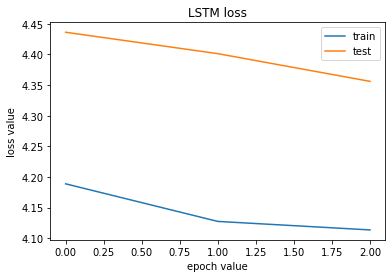

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss value')
plt.xlabel('epoch value')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
test_ids = test_df['Id'].unique()
y_pred = model.predict(X_test, batch_size=batch)
submission = pd.DataFrame({'Id': test_ids, 'Expected': y_pred.reshape(-1)})
submission.to_csv('submission.csv', index=False)